# Updated algorithm for determining LF ice edge

In [6]:
import numpy as np 
import cartopy
import cartopy.crs as ccrs
import matplotlib
matplotlib.interactive(True)
import cmocean
from netCDF4 import Dataset
import glob
import matplotlib.pyplot as plt
import datetime 
from datetime import date 
import mpl_toolkits.basemap as bm
import matplotlib.animation as animation
import numpy.ma as ma
import matplotlib.cm as cm
from matplotlib.patches import Polygon
from scipy import signal, stats
import time
from scipy.interpolate import interp1d
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings; warnings.simplefilter('ignore')
import seaborn as sns
from functions import trend, load_ice, plot_cartopy
from matplotlib import gridspec

# %matplotlib notebook

path = '/extra-space1/data/tikoralukupload/cis-weekly/nc/'
region = 'HB'

# Projection for mapping
rot = ccrs.RotatedPole(pole_latitude=55,pole_longitude=150)

# Read in data
nc = Dataset(path + region + '.nc', 'r')
lon = nc.variables['longitude'][600:1450,1700:]
lat = nc.variables['latitude'][600:1450,1700:]
juld = nc.variables['juld'][:]
land = nc.variables['land'][:][600:1450,1700:]
E_CT = nc.variables['E_CT'][:,600:1450,1700:]   
E_FA = nc.variables['E_FA'][:,600:1450,1700:]       


CT = np.nan*np.ones(E_CT.shape)
CT[E_CT==1] = 10
CT[E_CT==2] = 20
CT[E_CT==3] = 30
CT[E_CT==4] = 40
CT[E_CT==5] = 50
CT[E_CT==6] = 60
CT[E_CT==7] = 70
CT[E_CT==8] = 80
CT[E_CT==9] = 90
CT[E_CT==10] = 95
CT[E_CT==11] = 100


# Date time information
d0ord = date(1950,1,1).toordinal()
dt_ordinal = d0ord + juld
dates = [date.fromordinal(dt_ordinal[tt]) for tt in range(len(juld))]
months = [dates[tt].month for tt in range(len(juld))]
years = [dates[tt].year for tt in range(len(juld))]
months_unique = np.unique(months)
years_unique = np.unique(years)

In [7]:
# Convert to distance from degree. 1 degree lat = 110km. 1 degree lon = 111.320*cos(latitude) km.
def deg2km(lat,lon):
    u_km = lon*111*np.cos(lat)
    v_km = lat*111
    return abs(u_km), abs(v_km)

## Code for obtaining coastline points

Method: Search for the first masked value in i direction (towards coastline). Because some rows start with masked indices before the ocean (unmasked), look for first masked index after an unmasked index. For example, x > ~500 in the plot below:

953


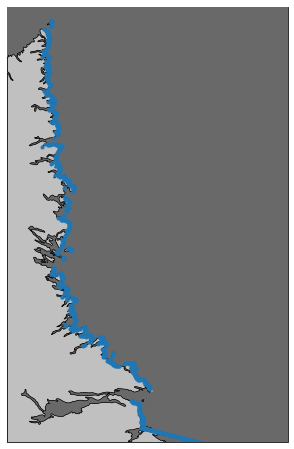

In [8]:
# Get coastline edge
m = np.shape(CT)[2]

coast_i = np.zeros((m))
coast_j = np.zeros((m))

# Mask lon and lat to get land               
ma_lon = ma.masked_array(lon, mask=land)
ma_lat = ma.masked_array(lat, mask=land)


for i in range(m):
    if ma_lon[:,i].count() !=0:
        # Get indef of the first masked value in row i
        first_unmasked = np.where(ma_lon.mask[:,i] == False)[0][0]
        # Array of masked indices in row i
        masked_indices = np.where(ma_lon.mask[:,i] == True)[0]
        # Most eastward point of the coastline in row i
        first_land = masked_indices[np.where(masked_indices > first_unmasked)][0]
        coast_i[i] = i
        coast_j[i] = first_land
        
    else:
        print(i)
        
coast_i = coast_i.astype(int)
coast_j = coast_j.astype(int)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1, projection=rot)
plot_cartopy(ax,lon,lat)
plt.plot(lon[coast_j,coast_i],lat[coast_j,coast_i],'.',transform=ccrs.PlateCarree(),zorder=4)

## Code for obtaining Sina points

In [9]:
# Which month?
mon = 5

CT=E_FA

m = np.shape(CT)[2]
n = np.shape(CT)[1]

sina_ii = np.zeros((m))
sina_jj = np.zeros((m))

sina_i = []
sina_j = []
dates_sina = []
juld_sina = []

for yr in years_unique:
    # Every year for the month defined by mon
    which = (years == yr) * (np.array(months) == mon)
    if np.sum(which) >= 1:
        # Save all observational days of the month
        tt = np.where(which)[0]
    for k in tt:
        sina_ii = np.zeros((m))
        sina_jj = np.zeros((m))
        for i in range(m):
            # Where there is ice
            not_nans = np.where(np.isnan(CT[k,:,i])==False)[0]
            sina_ii[i] = i
            # Check: Is there landfast ice in row i (CT=100)? If yes, save first index as sina point
            if 8 in CT[k,:,i]:
                # Don't count other regions of CT=100. Reverse so coming from west
                
                ### NOT WORKING
#                 CT100 = np.where(CT[k,:,i]==100.0)[0][::-1]
#                 spacing = np.subtract(CT100[:-1],CT100[1:])
#                 if len(np.where(spacing != 1)[0]) > 0:
#                     # If theres a jump then take the first element after the jump
#                     sina_point = CT100[np.where(spacing != 1)][0]
#                 else:
#                     # If no jump, take most eastward point of CT=100
                sina_point = np.where(CT[k,:,i]==8)[0][0]
                    
                ###
                
                # If the index is more west than the defined coastline, save coastline instead
                if sina_point <= coast_j[i]:
                    sina_jj[i] = sina_point
                else: 
                    sina_jj[i] = coast_j[i]
                
            # SHOULD there be LF ice? (Is there a gap between last CT point and coastline?)
            # Check: Is the coastline at the same location as last ice?
            # First non-nan ice value along j
            
            # Make sure there are non-nan values
            elif 8 not in CT[k,:,i] and len(not_nans)>0:
                last_ice = not_nans[-1]
                # If not at coastline, save as Sina, unless it's too far to be the true Sina (110km)
                if last_ice < coast_j[i]:# and abs(coast_j[i] - last_ice) < 97:
                    sina_jj[i] = last_ice
                else:
               # If the LF ice in CT is more west than the coastline, fill index with coastline coordinate.
                    if ma_lon[:,i].count() !=0: 
                        sina_jj[i] = coast_j[i]
            # If row is all nans:
            else:
                if ma_lon[:,i].count() !=0: 
                    sina_jj[i] = coast_j[i]
                
        sina_ii = sina_ii.astype(int)
        sina_jj = sina_jj.astype(int)
        dates_sina.append(dates[k])
        juld_sina.append(juld[k])
        sina_i.append(sina_ii)
        sina_j.append(sina_jj)

In [1521]:
k=1016
i=360
CT100 = np.where(CT[k,:,i]==100.0)[0][::-1]
spacing = np.subtract(CT100[:-1],CT100[1:])
if len(np.where(spacing != 1)[0]) > 0:
    # If theres a jump then take the first element after the jump
    sina_point = spacing[np.where(spacing != 1)][0]
    print('hi')
else:
    # If no jump, take most eastward point of CT=100
    sina_point = np.where(CT[k,:,i]==100.0)[0][0]

hi


In [26]:
dates[4]

datetime.date(1997, 5, 1)

In [34]:
len(E_CT)

1043

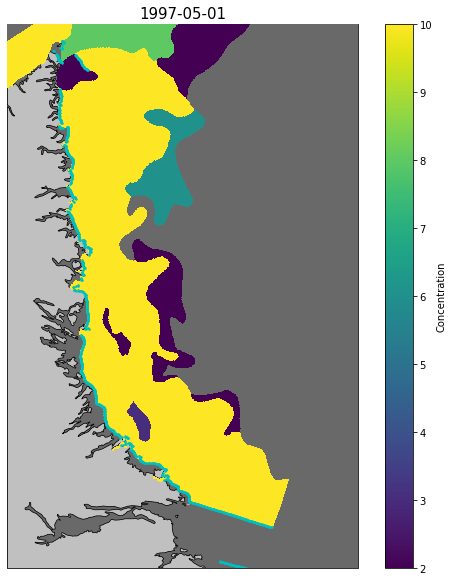

In [32]:
fig=plt.figure(figsize=(10,10),facecolor='white')
ax = fig.add_subplot(1,1,1, projection=rot)
plot_cartopy(ax,lon,lat)
plt.pcolormesh(lon,lat,E_CT[4,:,:],transform=ccrs.PlateCarree(),zorder=4)
i=0
plt.plot(lon[sina_j[i],sina_i[i]],lat[sina_j[i],sina_i[i]],'c.', markersize=3, transform=ccrs.PlateCarree(),zorder=4, label='Sina')
# plt.plot(lon[409,220],lat[409,220],'r*',transform=ccrs.PlateCarree(),zorder=4)
# plt.plot(lon[coast_j,coast_i],lat[coast_j,coast_i],'r.',markersize=2,transform=ccrs.PlateCarree(),zorder=4, label='Coastline')

plt.title(dates[4],fontsize=15)
plt.colorbar(label='Concentration')
plt.savefig('/home/mwang/')

How can we define landfast ice? CT=100 elsewhere away from the coastline. 

Visualize: Plot Sina against coastline

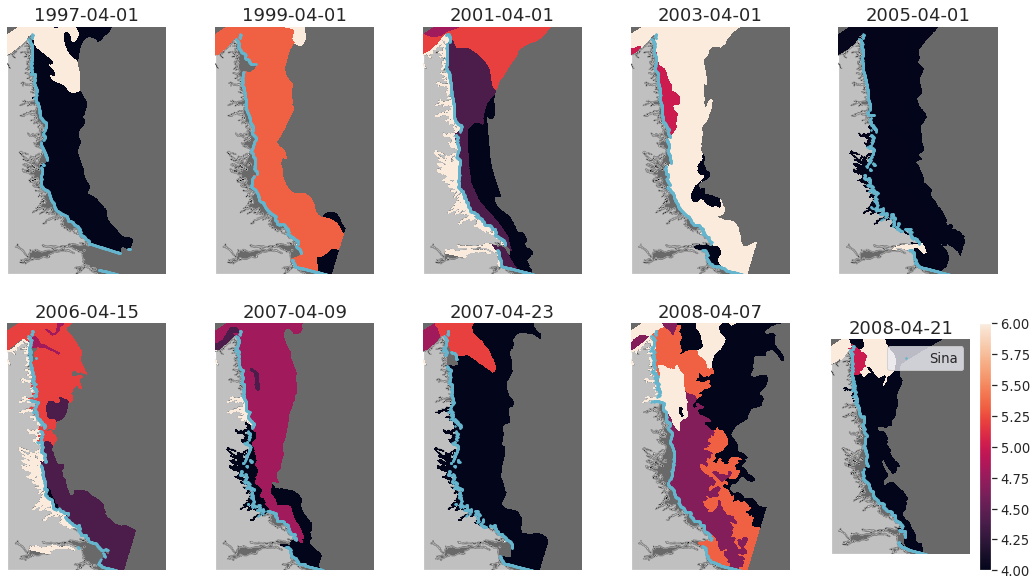

In [9]:
fig = plt.figure(figsize=(18,10))
# plt.pcolormesh(lon,lat,CT[tt,:,:],cmap='Blues_r')
sns.set(font_scale=1.2)

cnt = 1
# Just plot some dates
for i in np.arange(0,20,2):   
    ii = np.where(juld==juld_sina[i])[0][0]
    ax = fig.add_subplot(2,5,cnt, projection=rot)
    plot_cartopy(ax,lon,lat)
    plt.contourf(lon,lat,CT[ii,:,:],transform=ccrs.PlateCarree(),zorder=4)
    plt.plot(lon[sina_j[i],sina_i[i]],lat[sina_j[i],sina_i[i]],'c.', markersize=3, transform=ccrs.PlateCarree(),zorder=4, label='Sina')
#     plt.plot(lon[coast_j,coast_i],lat[coast_j,coast_i],'r.',markersize=2,transform=ccrs.PlateCarree(),zorder=4, label='Coastline')
    plt.title(dates_sina[i],fontsize=18)
    cnt+=1

plt.legend()
plt.colorbar()

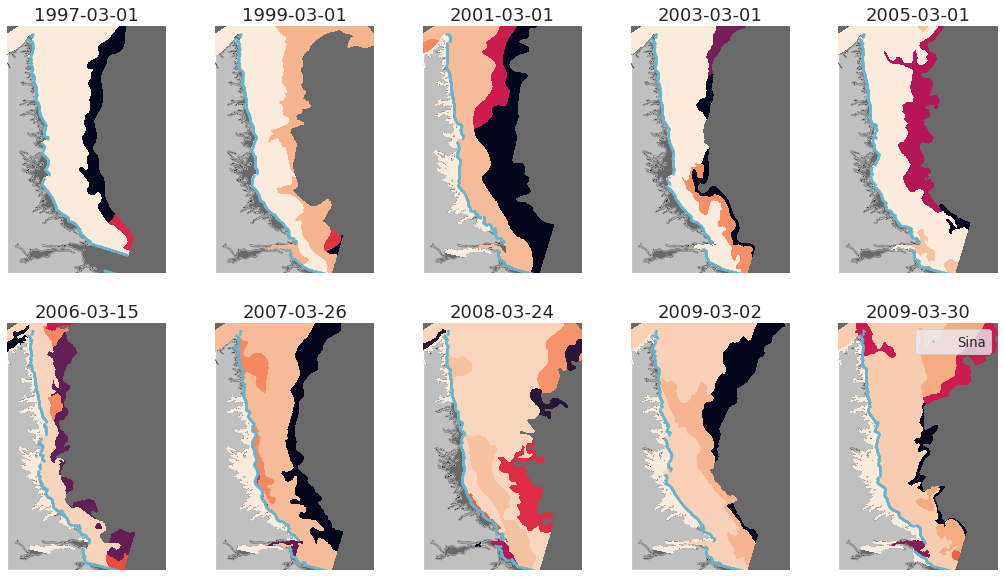

In [1266]:
fig = plt.figure(figsize=(18,10))
# plt.pcolormesh(lon,lat,CT[tt,:,:],cmap='Blues_r')
sns.set(font_scale=1.2)

cnt = 1
# Just plot some dates
for i in np.arange(0,20,2):   
    ii = np.where(juld==juld_sina[i])[0][0]
    ax = fig.add_subplot(2,5,cnt, projection=rot)
    plot_cartopy(ax,lon,lat)
    plt.pcolormesh(lon,lat,CT[ii,:,:],transform=ccrs.PlateCarree(),zorder=4)
    plt.plot(lon[sina_j[i],sina_i[i]],lat[sina_j[i],sina_i[i]],'c.', markersize=2, transform=ccrs.PlateCarree(),zorder=4, label='Sina')
#     plt.plot(lon[coast_j,coast_i],lat[coast_j,coast_i],'r.',markersize=2,transform=ccrs.PlateCarree(),zorder=4, label='Coastline')
    plt.title(dates_sina[i],fontsize=18)
    cnt+=1

plt.legend()

### Calculate distances between Sina and coastline

Reduce the domain to filter out weird points at N and S ends.

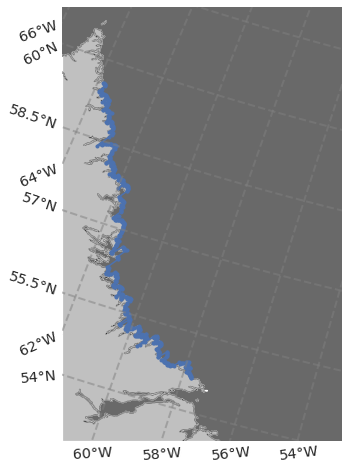

In [1399]:
m = len(dates_sina)
n = len(coast_j)
D_KM = np.zeros((m,n))

# Calculate the distance between Sina and coastline using deg2km
# for yr in range(len(D_KM)):
#     u_km, v_km = deg2km(lat[coast_j,coast_i], lon[sina_j[yr],sina_i[yr]]-lon[coast_j,coast_i])
#     D_KM[yr,:] = u_km


# Calculate the distance between Sina and coastline using grid points
for day in range(len(D_KM)):
    D_KM[day,:] = abs(sina_j[day]-coast_j)

# Reduce domain (see map below)
Nbound = 150
Sbound = -200
d_km = D_KM[:,Nbound:Sbound]
            
# Calculate trend           
ytrend = np.zeros(np.shape(d_km)[1])
#     dtrend_95=np.zeros(np.shape(d_km)[1])
#     ybar=np.zeros(np.shape(d_km)[1])

for i in range(np.shape(d_km)[1]):
    mean, tr, dt95 = trend(np.array(juld_sina),d_km[:,i])
    ytrend[i] = tr
#         dtrend_95[i] = dt95
#         ybar[i] = mean

# Visualize reduced domain
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1, projection=rot)
plot_cartopy(ax,lon,lat)
plt.plot(lon[coast_j[Nbound:Sbound],coast_i[Nbound:Sbound]],lat[coast_j[Nbound:Sbound],coast_i[Nbound:Sbound]],'.-',transform=ccrs.PlateCarree(),zorder=4)

# Add gridlines
sns.set(font_scale=1.2)
g = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--',zorder=5,x_inline=False, y_inline=False)
g.ylabels_right = False
g.xlabels_top = False

### Plot Heatmap
 (with new reduced domain)

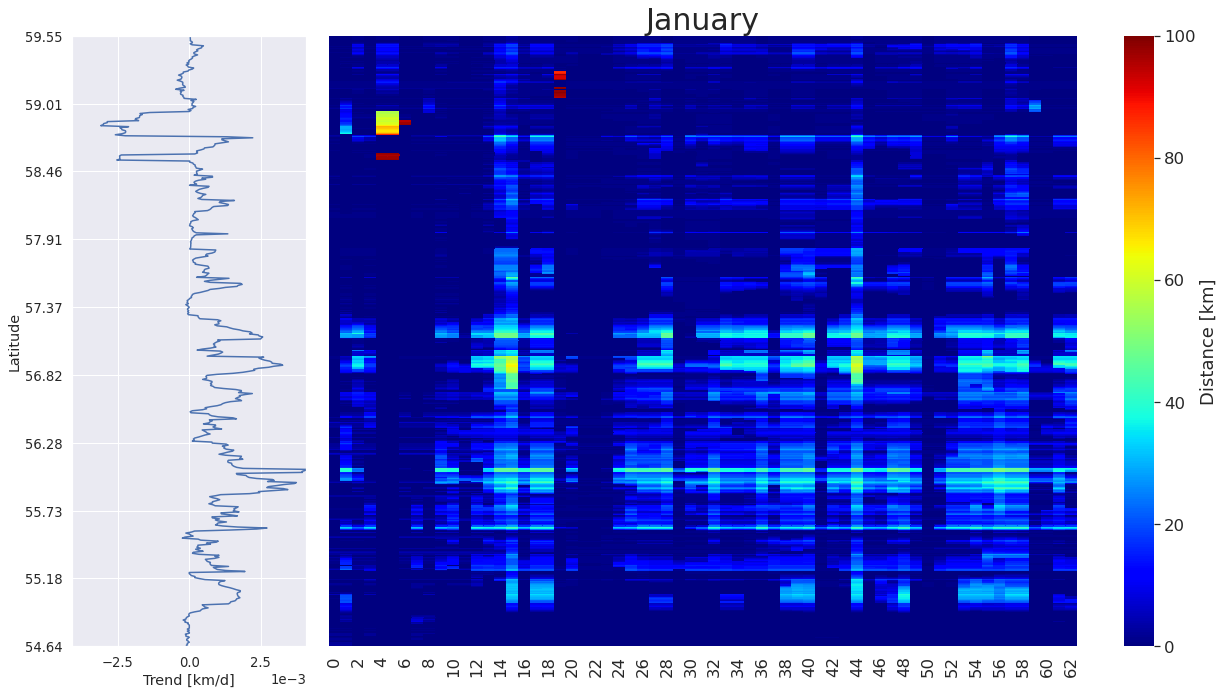

In [1395]:
# Heatmap
fig = plt.figure(figsize=(18,10))
# Alter width ratios of subplots for trend plotting
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 4]) 
ax = fig.add_subplot(gs[0])

# New domain
coastlon = lon[coast_j[Nbound:Sbound],coast_i[Nbound:Sbound]]
coastlat = lat[coast_j[Nbound:Sbound],coast_i[Nbound:Sbound]]

# Plot trends
sns.set(font_scale=1.5)
# Plot reverse so latitude decreases from top to bottom
plt.plot(ytrend[::-1],np.arange(0,len(ytrend)))
# Label from high to low lat
ytick_labels = np.round(np.linspace(coastlat[0],coastlat[-1],10),2)
plt.yticks(np.linspace(d_km.shape[1],0,10), ytick_labels)  # Set text labels and properties.
plt.xlabel('Trend [km/d]')
plt.ylabel('Latitude')
plt.ylim([0,d_km.shape[1]])
# Normalize x axis
plt.xlim([-1*np.max(abs(ytrend)),np.max(abs(ytrend))])
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

# Plot heatmap
ax = fig.add_subplot(gs[1])

# Flip it so y axis increases with latitude
d_km_arr = np.array(d_km)
# Plot heatmap of distance
ax = sns.heatmap(d_km_arr.transpose(), cmap='jet', cbar_kws={'label': 'Distance [km]'}, vmin=0, vmax=100)
# ax.invert_yaxis()
ax.set_yticks(np.linspace(d_km_arr.shape[1],0,10))
# ax.set_yticklabels(ytick_labels)
# xtick_labels = dates_sina
# ax.set_xticks(np.linspace(0,len(dates_sina),5))
# ax.set_xticklabels(xtick_labels,rotation='vertical')

# Only call set font scale once. to undo, call sns.reset_defaults()
# sns.set(font_scale=1.4)

cbar = ax.collections[0].colorbar
mon_str = ['January','February','March','April','May']
plt.title(mon_str[mon-1],fontsize=30)
plt.tight_layout()
# plt.savefig('/home/mwang/CIS-project/figures/May19_LF_March_heatmap')


In [768]:
# Display date information (doesn't fit on plot)
# import pandas as pd
# pd.DataFrame(dates_sina, columns=["date"])

Text(0.5, 1.0, 'd_km anomolies (km)')

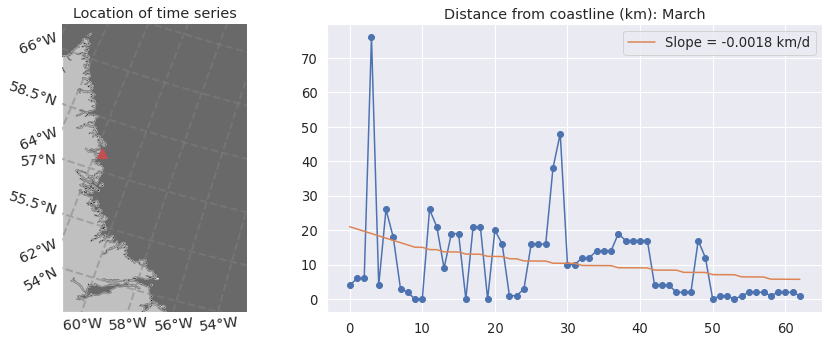

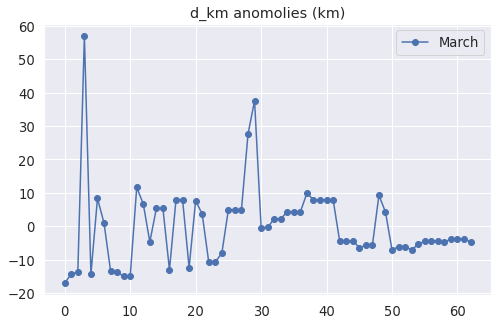

In [1374]:
# sns.reset_defaults()
sns.set(font_scale=1.2)

# Pick a location on the map
tt = 372
fig = plt.figure(figsize=(12,5))
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 3]) 
# ax = fig.add_subplot(1,2,1, projection=rot)
ax = fig.add_subplot(gs[0], projection=rot)
plot_cartopy(ax,lon,lat)

# Mark position
ax.plot(lon[coast_j[tt],coast_i[tt]], lat[coast_j[tt],coast_i[tt]],'r^', markersize=10,transform=ccrs.PlateCarree(),zorder=4)

# Add gridlines
g = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--',zorder=5,x_inline=False, y_inline=False)
g.ylabels_right = False
g.xlabels_top = False
plt.title('Location of time series')

ax = fig.add_subplot(gs[1])
plt.plot(d_km[:,tt],'o-')
s,b = np.polyfit(juld_sina,d_km[:,tt],1)
plt.plot(ytrend[tt]*np.array(juld_sina) + b, label=f"Slope = {np.round(s,4)} km/d")
plt.title('Distance from coastline (km): ' + mon_str[mon-1] )
# Fix x tick labels
# plt.xticks(np.arange(0, len(d_km), 1.0))
# xtick_labels = years_unique
# ax.set_xticklabels(xtick_labels,rotation='vertical')
plt.tight_layout()
plt.legend()

# Subtract trend from mean to get anomolies

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
anom = d_km[:,tt] - (np.array(juld_sina)*ytrend[tt] + b) 
plt.plot(anom,'o-', label=mon_str[mon-1])
# plt.xticks(np.arange(0, len(d_km), 1.0))
# xtick_labels = years_unique
# ax.set_xticklabels(xtick_labels,rotation='vertical')
plt.legend()
plt.title('d_km anomolies (km)')

Slope is not linear because dates are not. Will be better once months are grouped together so time is only in years. However, perhaps we would lose important information? ie. if LF ice changed drastically in March of one year, we would want that information. 

# Area of LF Ice

Needs revising. Not sure if this is the right way... 

Average is lower than when using integration method

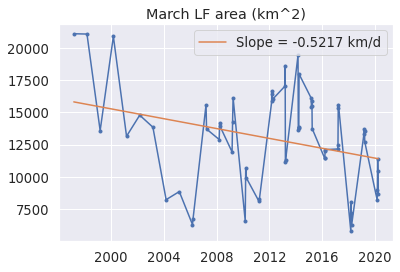

In [1376]:
# Resolution is 1km x 1km. Count how many points in each row and sum up total of all rows.

area = np.zeros(len(dates_sina))
for day in range(len(area)):
    area[day] = sum(abs(sina_j[day]-coast_j))

s,b = np.polyfit(juld_sina,area,1)

plt.figure()
plt.plot(dates_sina,area,'.-')
plt.plot(dates_sina,np.array(juld_sina)*s + b,label=f"Slope = {np.round(s,4)} km/d")
plt.title(mon_str[mon-1] + ' LF area (km^2)')
plt.legend()

In [1]:
700*650*28

12740000